In [1]:
# Basic imports and utilities
import os
import re
import json
import random
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import requests

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
if not os.path.exists('Sherlock.csv'):
    print("Downloading Sherlock dataset...")
    url = "https://www.gutenberg.org/files/1661/1661-0.txt"
    response = requests.get(url)
    with open('Sherlock.csv', 'w') as f:
        f.write(response.text)
    print("Download complete!")
else:
    print("File already exists, skipping download.")

Download complete!


In [5]:
# Read and preprocess the text
with open('Sherlock.csv', 'r', encoding='utf-8') as f:
    text = f.read()

# Remove special characters except alphanumeric, space, and full stop
cleaned_text = re.sub('[^a-zA-Z0-9 \.]', ' ', text)

# Convert to lowercase
cleaned_text = cleaned_text.lower()

# Split into sentences using full stop
sentences = [s.strip() for s in cleaned_text.split('.') if s.strip()]

# Extract all words
words = []
for sentence in sentences:
    words.extend(sentence.split())

# Create vocabulary from unique words
vocabulary = set(words)
vocab_size = len(vocabulary)

# Count word frequencies
word_counts = Counter(words)

# Get most and least frequent words
most_frequent = word_counts.most_common(10)
least_frequent = word_counts.most_common()[:-11:-1]  # Last 10 in reverse order

# Report statistics
print(f"Vocabulary Size: {vocab_size}")
print(f"\nTotal words in corpus: {len(words)}")
print(f"\n{'='*50}")
print("10 Most Frequent Words:")
print(f"{'='*50}")
for word, count in most_frequent:
    print(f"{word:20s} : {count:6d}")

print(f"\n{'='*50}")
print("10 Least Frequent Words:")
print(f"{'='*50}")
for word, count in least_frequent:
    print(f"{word:20s} : {count:6d}")

# Save vocabulary and word counts for later use
vocab_data = {
    'vocabulary': list(vocabulary),
    'word_counts': dict(word_counts),
    'vocab_size': vocab_size
}

with open('vocab_data.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)

print(f"\n{'='*50}")
print("Vocabulary data saved to 'vocab_data.pkl'")

Vocabulary Size: 8150

Total words in corpus: 109148

10 Most Frequent Words:
the                  :   5822
and                  :   3085
i                    :   3038
to                   :   2826
of                   :   2781
a                    :   2700
in                   :   1826
that                 :   1767
it                   :   1749
you                  :   1577

10 Least Frequent Words:
newsletter           :      1
subscribe            :      1
includes             :      1
pg                   :      1
edition              :      1
necessarily          :      1
network              :      1
originator           :      1
hart                 :      1
michael              :      1

Vocabulary data saved to 'vocab_data.pkl'


<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_6692/4240199497.py:6: SyntaxWarning: invalid escape sequence '\.'
  cleaned_text = re.sub('[^a-zA-Z0-9 \.]', ' ', text)


In [6]:
# Create word to index and index to word mappings
word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"Created mappings for {len(word_to_idx)} words")

Created mappings for 8150 words


In [7]:
# Create training sequences (context window = 3 words to predict next word)
def create_sequences(words, window_size=3):
    sequences = []
    targets = []
    
    for i in range(len(words) - window_size):
        seq = words[i:i+window_size]
        target = words[i+window_size]
        
        # Convert to indices
        seq_indices = [word_to_idx[word] for word in seq]
        target_idx = word_to_idx[target]
        
        sequences.append(seq_indices)
        targets.append(target_idx)
    
    return np.array(sequences), np.array(targets)

# Create sequences
window_size = 3
X, y = create_sequences(words, window_size)
X = torch.tensor(X).to(device)
y = torch.tensor(y).to(device)

print(f"Created {len(X)} training sequences")
print(f"Sequence shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Created 109145 training sequences
Sequence shape: torch.Size([109145, 3])
Target shape: torch.Size([109145])

Training samples: 87316
Validation samples: 21829


In [8]:
# Define MLP Text Generator Model
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim=32, hidden_dim=1024, window_size=3):
        super(MLPTextGenerator, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_dim = embedding_dim * window_size
        
        # MLP layers
        self.fc1 = nn.Linear(self.input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        # x shape: (batch_size, window_size)
        batch_size = x.size(0)
        
        # Embed each word
        embedded = self.embedding(x)  # (batch_size, window_size, embedding_dim)
        
        # Flatten embeddings
        embedded = embedded.view(batch_size, -1)  # (batch_size, window_size * embedding_dim)
        
        # Pass through MLP
        h1 = self.dropout1(self.relu1(self.fc1(embedded)))
        output = self.fc2(h1)
        
        return output

# Initialize model
model = MLPTextGenerator(vocab_size, embedding_dim=32, hidden_dim=1024, window_size=window_size)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:\n{model}")


Total parameters: 8,713,878
Trainable parameters: 8,713,878

Model architecture:
MLPTextGenerator(
  (embedding): Embedding(8150, 32)
  (fc1): Linear(in_features=96, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=8150, bias=True)
)


In [9]:
# Training function
def train_epoch(model, X_train, y_train, optimizer, criterion, batch_size=128):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Shuffle training data
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    num_batches = len(X_train) // batch_size
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        batch_X = torch.LongTensor(X_train_shuffled[start_idx:end_idx]).to(device)
        batch_y = torch.LongTensor(y_train_shuffled[start_idx:end_idx]).to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / num_batches
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, X_val, y_val, criterion, batch_size=128):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    num_batches = len(X_val) // batch_size
    
    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            batch_X = torch.LongTensor(X_val[start_idx:end_idx]).to(device)
            batch_y = torch.LongTensor(y_val[start_idx:end_idx]).to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / num_batches
    accuracy = 100 * correct / total
    return avg_loss, accuracy

print("Training and validation functions defined")

Training and validation functions defined


In [11]:
# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
batch_size = 16384

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training...")
print(f"{'='*60}")

best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, X_train.cpu().numpy(), y_train.cpu().numpy(), optimizer, criterion, batch_size)
    
    # Validate
    val_loss, val_acc = validate(model, X_val.cpu().numpy(), y_val.cpu().numpy(), criterion, batch_size)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    

    
    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"{'='*60}")

print("\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


Starting training...


Epoch [100/1000]
  Train Loss: 2.2034 | Train Acc: 45.30%
  Val Loss:   7.8947 | Val Acc:   12.72%
Epoch [200/1000]
  Train Loss: 1.7378 | Train Acc: 53.29%
  Val Loss:   8.5463 | Val Acc:   13.14%
Epoch [300/1000]
  Train Loss: 1.4647 | Train Acc: 58.99%
  Val Loss:   9.0278 | Val Acc:   12.99%
Epoch [400/1000]
  Train Loss: 1.2727 | Train Acc: 63.33%
  Val Loss:   9.5066 | Val Acc:   12.88%
Epoch [500/1000]
  Train Loss: 1.1374 | Train Acc: 66.39%
  Val Loss:   9.9778 | Val Acc:   12.82%
Epoch [600/1000]
  Train Loss: 1.0289 | Train Acc: 68.75%
  Val Loss:   10.4384 | Val Acc:   12.80%
Epoch [700/1000]
  Train Loss: 0.9346 | Train Acc: 71.11%
  Val Loss:   10.9017 | Val Acc:   12.83%
Epoch [800/1000]
  Train Loss: 0.8652 | Train Acc: 72.68%
  Val Loss:   11.3609 | Val Acc:   12.71%
Epoch [900/1000]
  Train Loss: 0.8089 | Train Acc: 74.19%
  Val Loss:   11.8160 | Val Acc:   12.79%
Epoch [1000/1000]
  Train Loss: 0.7616 | Train Acc: 75.32%
  Val Loss:   12.2575 | Val Acc:   12.45%

Tra

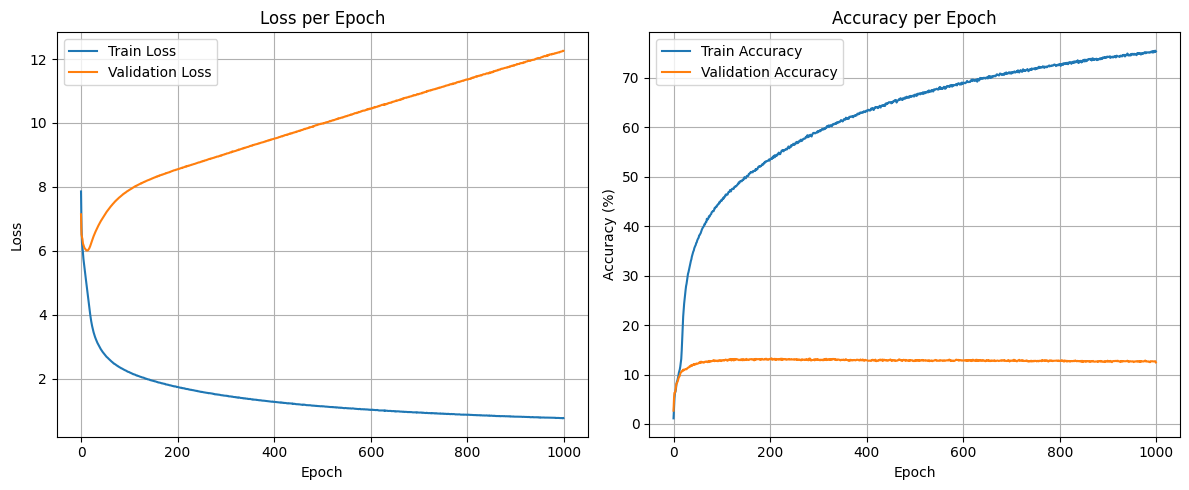


Final Training Accuracy: 75.32%
Final Validation Accuracy: 12.45%


In [12]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final accuracy
print(f"\nFinal Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

In [13]:
# Save the trained model with all necessary metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': 32,
    'hidden_dim': 1024,
    'window_size': window_size,
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word
}, 'mlp_text_model_dataset1.pth')

print("Model saved successfully!")

Model saved successfully!


In [14]:
# Select interesting words for visualization
word_categories = {
    'Characters': ['holmes', 'watson', 'moriarty', 'lestrade', 'hudson', 'mary', 'john', 'inspector'],
    'Pronouns': ['i', 'you', 'he', 'she', 'we', 'they', 'him', 'her'],
    'Actions': ['said', 'asked', 'looked', 'saw', 'went', 'came', 'found', 'knew'],
    'Locations': ['london', 'street', 'room', 'house', 'door', 'window', 'office', 'station'],
    'Objects': ['letter', 'paper', 'hand', 'face', 'case', 'man', 'woman', 'time'],
    'Emotions': ['strange', 'curious', 'remarkable', 'singular', 'interesting', 'mysterious', 'evident', 'clear'],
    'Question_Words': ['what', 'when', 'where', 'why', 'how', 'who', 'which'],
    'Common_Words': ['the', 'a', 'and', 'of', 'to', 'in', 'it', 'is']
}

# Collect all words that exist in vocabulary
selected_words = []
word_labels = []
word_colors = []

color_map = {
    'Characters': 'red',
    'Pronouns': 'blue',
    'Actions': 'green',
    'Locations': 'purple',
    'Objects': 'orange',
    'Emotions': 'brown',
    'Question_Words': 'pink',
    'Common_Words': 'gray'
}

for category, words in word_categories.items():
    for word in words:
        if word in word_to_idx:
            selected_words.append(word)
            word_labels.append(category)
            word_colors.append(color_map[category])

print(f"Selected {len(selected_words)} words for visualization")
print(f"\nWords per category:")
for category in word_categories.keys():
    count = word_labels.count(category)
    print(f"  {category}: {count}")

Selected 62 words for visualization

Words per category:
  Characters: 7
  Pronouns: 8
  Actions: 8
  Locations: 8
  Objects: 8
  Emotions: 8
  Question_Words: 7
  Common_Words: 8


In [15]:
# Load checkpoint and extract embeddings directly
checkpoint = torch.load('mlp_text_model_dataset1.pth', map_location=device)

# Get the state dict
if isinstance(checkpoint, dict):
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    # Extract embeddings directly from state dict
    embedding_weights = state_dict['embedding.weight'].cpu().numpy()

    # Get vocabulary if available
    word_to_idx = checkpoint.get('word_to_idx', None)
    if word_to_idx:
        idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"Embedding shape: {embedding_weights.shape}")
print(f"Vocabulary size: {embedding_weights.shape[0]}")
print(f"Embedding dimension: {embedding_weights.shape[1]}")

Embedding shape: (8150, 32)
Vocabulary size: 8150
Embedding dimension: 32


In [16]:
# Get embeddings for selected words
selected_indices = [word_to_idx[word] for word in selected_words]
selected_embeddings = embedding_weights[selected_indices]

print(f"Selected embeddings shape: {selected_embeddings.shape}")

Selected embeddings shape: (62, 32)


In [17]:

print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(selected_words)-1),
n_iter=1000, learning_rate=200)
embeddings_2d = tsne.fit_transform(selected_embeddings)

print(f"t-SNE embeddings shape: {embeddings_2d.shape}")

Applying t-SNE dimensionality reduction...
t-SNE embeddings shape: (62, 2)


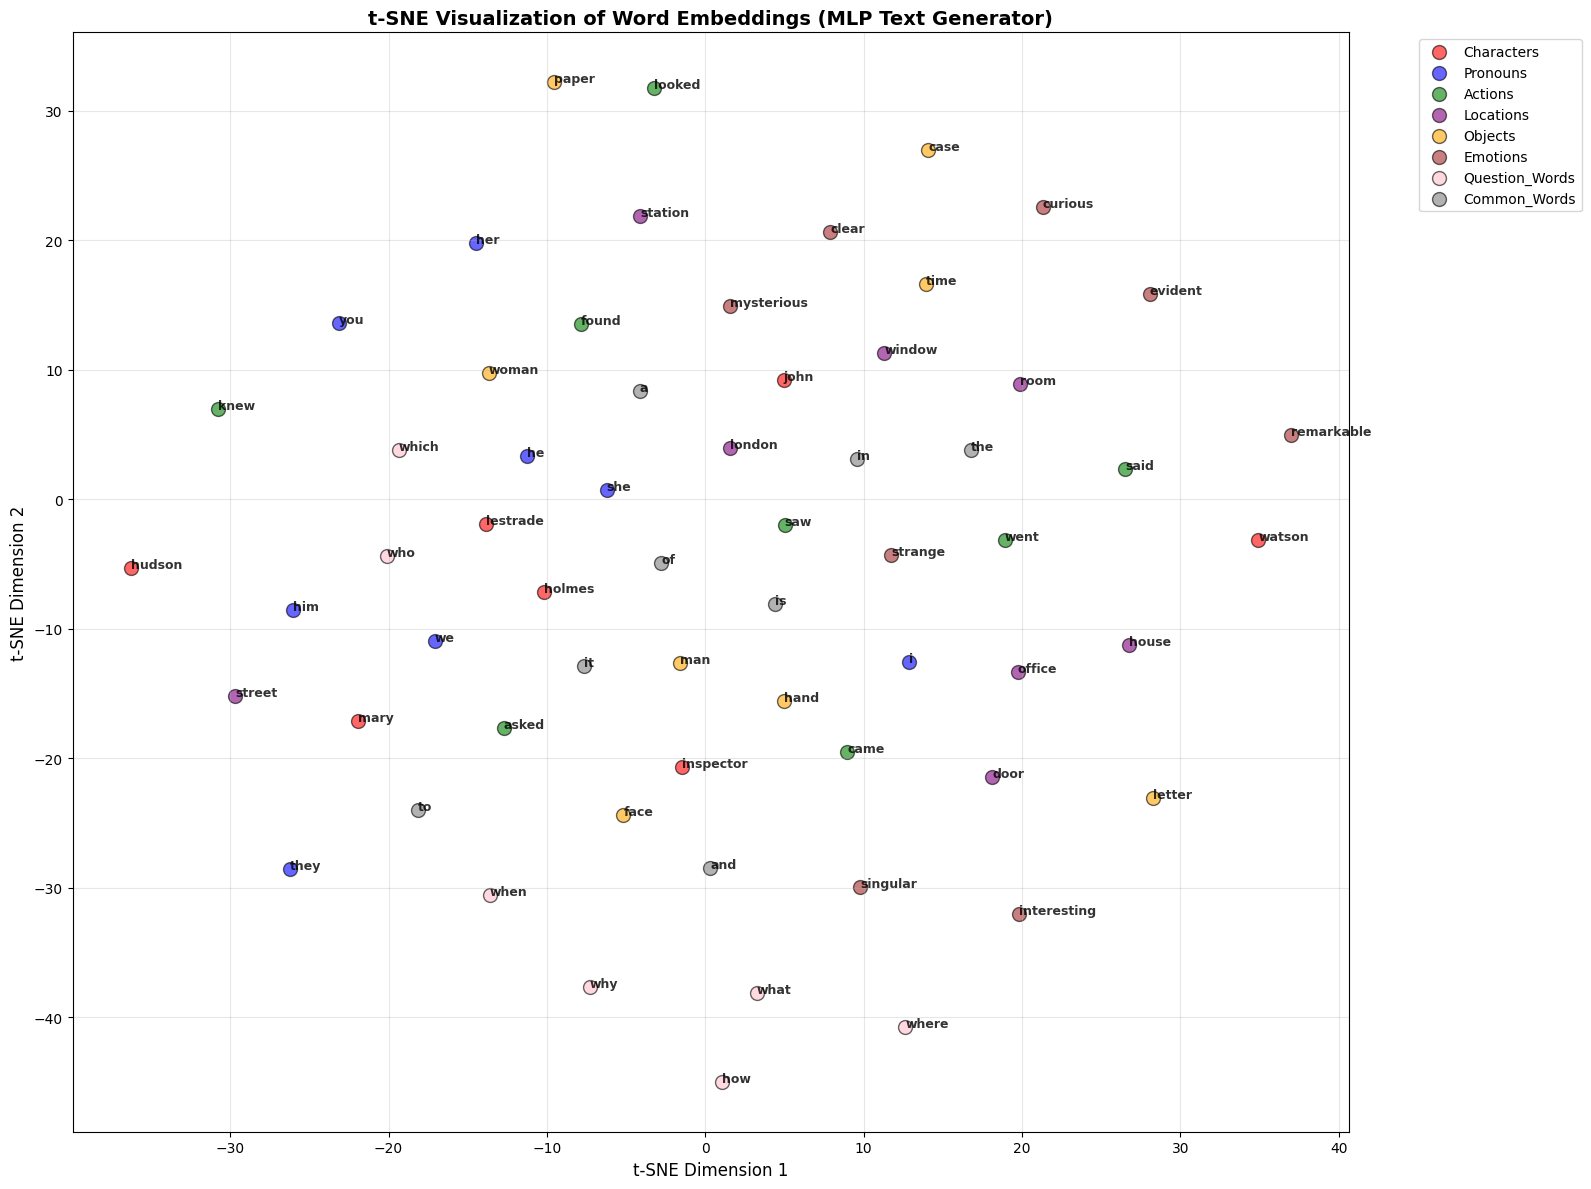

In [18]:
# Visualize embeddings with t-SNE
plt.figure(figsize=(16, 12))

# Create scatter plot with different colors for each category
for category, color in color_map.items():
    indices = [i for i, label in enumerate(word_labels) if label == category]
    if indices:
        x = [embeddings_2d[i, 0] for i in indices]
        y = [embeddings_2d[i, 1] for i in indices]
        plt.scatter(x, y, c=color, label=category, s=100, alpha=0.6, edgecolors='black')

        # Add word labels
        for i in indices:
            plt.annotate(selected_words[i],
                        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                        fontsize=9, alpha=0.8, fontweight='bold')

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('t-SNE Visualization of Word Embeddings (MLP Text Generator)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()